In [21]:
!pip install pandas

     ---------------------------------------- 10.4/10.4 MB 1.8 MB/s eta 0:00:00
     -------------------------------------- 498.1/498.1 kB 4.5 MB/s eta 0:00:00


In [22]:
from tensorflow import lite
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import random, os
import cv2
import shutil
import keras
import matplotlib.pyplot as plt
from matplotlib.image import imread
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_accuracy
from sklearn.model_selection import train_test_split

In [23]:
df = pd.read_csv("train.csv")

diagnosis_binary = {
        0: 'No_DR',
        1: 'DR',
        2: 'DR',
        3: 'DR',
        4: 'DR'}

diagnosis_classes = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR',
}


df["binary"] = df["diagnosis"].map(diagnosis_binary.get)
df["type"] = df["diagnosis"].map(diagnosis_classes.get)

<AxesSubplot: >

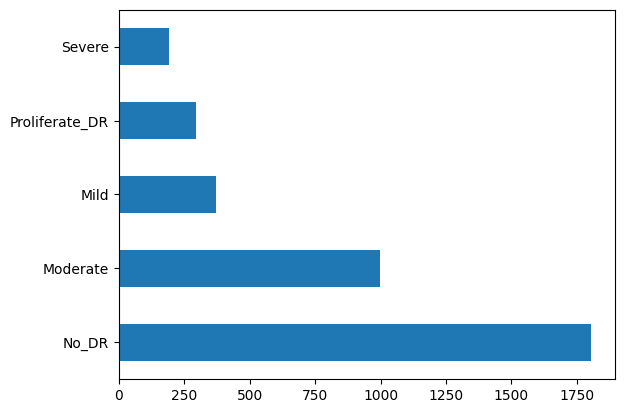

In [24]:
df['type'].value_counts().plot(kind='barh')

<AxesSubplot: >

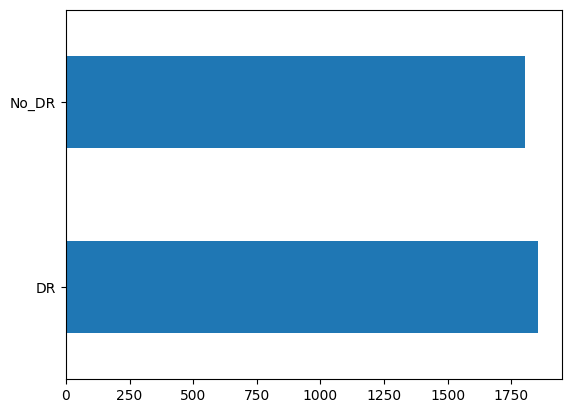

In [25]:
df['binary'].value_counts().plot(kind='barh')

In [27]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.preprocessing import LabelBinarizer
!pip install imutils
from imutils import paths
from sklearn.utils import shuffle

In [28]:
data = []
labels = []
width,height=224,224

imagePaths = list(paths.list_images('gaussian_filtered_images'))

data = []
labels = []

for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]   
    image = load_img(imagePath, target_size=(width, height))
    image = img_to_array(image)
    data.append(image)
    labels.append(label)

data = np.array(data, dtype="float32")
labels = np.array(labels)

lb = LabelBinarizer()
labels = lb.fit_transform(labels)

data, labels = shuffle(data, labels)

print(data.shape)
print(labels.shape)

(3662, 224, 224, 3)
(3662, 5)


In [29]:
data = data / 255.0

In [30]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=.2)

print("Train images:",x_train.shape)
print("Test images:",x_test.shape)
print("Train label:",y_train.shape)
print("Test label:",y_test.shape)

Train images: (2929, 224, 224, 3)
Test images: (733, 224, 224, 3)
Train label: (2929, 5)
Test label: (733, 5)


In [31]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=.2)

print("Train images:",x_train.shape)
print("Test images:",x_val.shape)
print("Train label:",y_train.shape)
print("Test label:",y_val.shape)

Train images: (2343, 224, 224, 3)
Test images: (586, 224, 224, 3)
Train label: (2343, 5)
Test label: (586, 5)


In [33]:
from keras.models import Model
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, BatchNormalization, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.applications.vgg16 import VGG16
from keras import layers

In [34]:
Vgg16 = VGG16(include_top=False, input_shape= (224,224,3)) 

Vgg16.trainable=False

58889256/58889256 [==============================] - 197s 3us/step


In [36]:
model = Sequential()
model.add(Vgg16)
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64 , activation="relu"))
model.add(Dropout(0.25))
model.add(Dense(32 , activation="relu"))
#model.add(Dropout(0.25))
model.add(Dense(5 , activation="sigmoid"))

model.compile( optimizer="adam" , loss="binary_crossentropy" , metrics="binary_accuracy")

In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 dropout (Dropout)           (None, 7, 7, 512)         0         
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 64)                1605696   
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 5)                 1

In [38]:
callbacks = [EarlyStopping(monitor='val_binary_accuracy' , patience=10 , restore_best_weights=True)]

history = model.fit(x_train , y_train , epochs=50 , batch_size=64,
                    validation_data=(x_val,y_val), verbose=1 , callbacks=callbacks)

Epoch 1/50
37/37 [==============================] - 390s 11s/step - loss: 0.4450 - binary_accuracy: 0.8058 - val_loss: 0.2771 - val_binary_accuracy: 0.8939
Epoch 2/50
37/37 [==============================] - 434s 12s/step - loss: 0.2979 - binary_accuracy: 0.8830 - val_loss: 0.2534 - val_binary_accuracy: 0.8966
Epoch 3/50
37/37 [==============================] - 464s 13s/step - loss: 0.2802 - binary_accuracy: 0.8890 - val_loss: 0.2492 - val_binary_accuracy: 0.8986
Epoch 4/50
37/37 [==============================] - 480s 13s/step - loss: 0.2707 - binary_accuracy: 0.8897 - val_loss: 0.2528 - val_binary_accuracy: 0.8956
Epoch 5/50
37/37 [==============================] - 475s 13s/step - loss: 0.2625 - binary_accuracy: 0.8951 - val_loss: 0.2440 - val_binary_accuracy: 0.8997
Epoch 6/50
37/37 [==============================] - 474s 13s/step - loss: 0.2559 - binary_accuracy: 0.8976 - val_loss: 0.2442 - val_binary_accuracy: 0.9003
Epoch 7/50
37/37 [==============================] - 478s 13s/ste

In [39]:
import os.path
if os.path.isfile('models/trained_model.h5') is False:
    model.save('models/trained_model.h5')

In [40]:
from tensorflow.keras.models import load_model
new_model = load_model('models/trained_model.h5')

In [41]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 dropout (Dropout)           (None, 7, 7, 512)         0         
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 64)                1605696   
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 5)                 1

In [43]:
def plot_curves(history):

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["binary_accuracy"]
  val_accuracy = history.history["val_binary_accuracy"]

  epochs = range(len(history.history["loss"]))

  #plot loss
  plt.plot(epochs, val_loss, label = "val_loss")
  plt.plot(epochs, loss, label = "training_loss")
  plt.xlabel("epochs")
  plt.title("loss")
  plt.legend()

  #plot accuracy
  plt.figure() 
  plt.plot(epochs, accuracy, label = "training_accuracy")
  plt.plot(epochs, val_accuracy, label = "val_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()

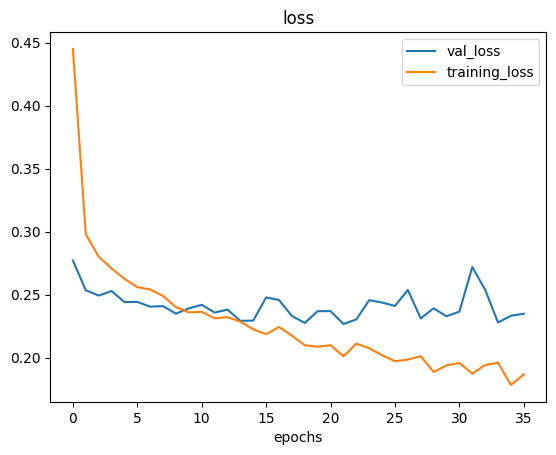

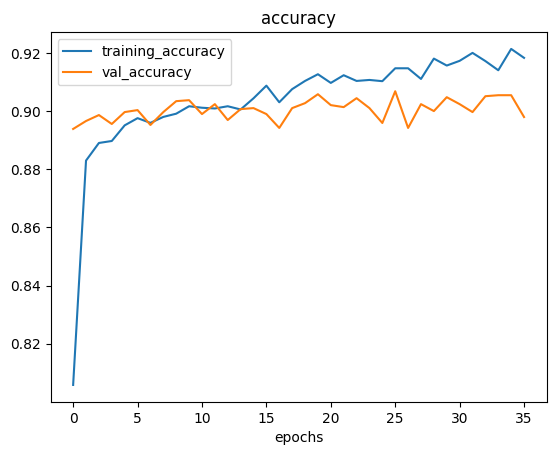

In [44]:
plot_curves(history)

In [45]:
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)

23/23 [==============================] - 89s 4s/step


[0 0 1 0 0]
Prediction: NO_DR


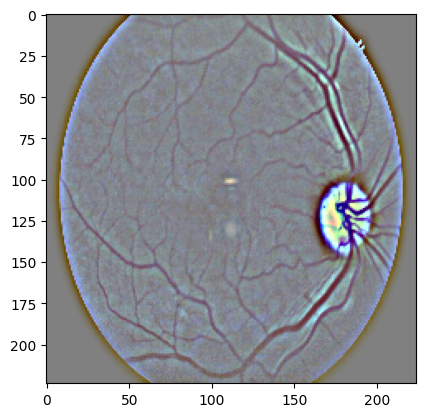

In [46]:
index =5
predictions=["Mild","Moderate","NO_DR","Proliferate_DR","Severe"] 

img = x_test[index]
RGBImg = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
RGBImg= cv2.resize(RGBImg,(224,224))

plt.imshow(RGBImg)
print(y_test[index]) # true
print(f"Prediction: {predictions[pred[index]]}")# predicted

In [47]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
predictions=["Mild","Moderate","NO_DR","Proliferate_DR","Severe"] 
def predict_new(path):
    img = cv2.imread(path)

    RGBImg = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    RGBImg= cv2.resize(RGBImg,(224,224))
    plt.imshow(RGBImg)
    image = np.array(RGBImg) / 255.0

    predict=new_model.predict(np.array([image]))
    pred=np.argmax(predict,axis=1)
    
    print(f"Predicted: {predictions[pred[0]]}")

1/1 [==============================] - 0s 427ms/step
Predicted: Mild


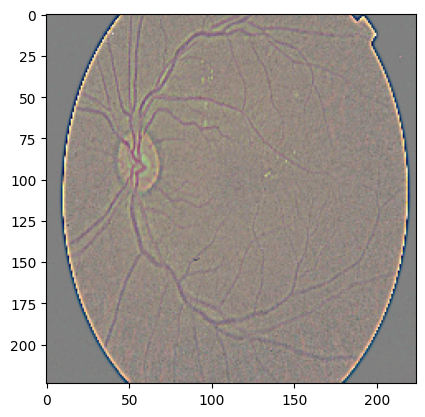

In [48]:
predict_new("gaussian_filtered_images/Mild/01b3aed3ed4c.png")